# Cost of Comfort

- Train a neural ODE model to predict temperature dynamics and power usage for a residential building
- Rollout for a month prediction of energy usage if temperature setpoint changes

In [1]:
from jax import config 
config.update("jax_debug_nans", False)
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp 
import flax.linen as nn
import optax 
import pandas as pd 

from dynax.core.base_block_state_space import BaseContinuousBlockSSM
from dynax.simulators.simulator import DifferentiableSimulator
from dynax.trainer.train_state import TrainState

## 0. Data
- EP data with prototypical building model
- Real data from Lennox thermostat data

In [2]:
"""
import pandas as pd 

dates = ['01-'+str(i)+'-18' for i in range(14, 28)]
data = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)

combined_data = pd.DataFrame()
for key in data.keys():
    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)

combined_data.to_csv('./data/real-world-data.csv')
"""

"\nimport pandas as pd \n\ndates = ['01-'+str(i)+'-18' for i in range(14, 28)]\ndata = pd.read_excel('./data/real-world-data.xls', sheet_name=dates, header=3)\n\ncombined_data = pd.DataFrame()\nfor key in data.keys():\n    combined_data = pd.concat([combined_data, data[key]], axis=0, ignore_index=True)\n\ncombined_data.to_csv('./data/real-world-data.csv')\n"

In [3]:
data = pd.read_csv('./data/real-world-data.csv')

columns_mapper = {'LocalTime':'time', 'tabtsense0':'temp_zone', 'SP_cool':'csp', 'SP_heat':'hsp', 'CoolDemand':'qcool', 'HeatDemand':'qheat', 'humidityindoor_0':'rh_zone', 'oupresentcompressorfreq':'freq', 'iuairflowrate':'cfm', 'surf_tempf':'temp_out', 'rad':'qsol'}

data = data[columns_mapper.keys()].rename(columns = columns_mapper)
data.index = pd.DatetimeIndex(data['time'], freq='1min')
data = data.drop(columns=['time'])


In [4]:
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:01:00,69.6,77,70,0,100,35.5,NaN,0,41.531667,0.0
2018-01-14 18:02:00,69.5,77,70,0,100,36.0,NaN,0,41.563333,0.0
2018-01-14 18:03:00,69.5,77,70,0,100,36.0,NaN,0,41.595000,0.0
2018-01-14 18:04:00,69.6,77,70,0,100,36.0,NaN,0,41.626667,0.0
2018-01-14 18:05:00,69.6,77,70,0,100,36.0,NaN,0,41.658333,0.0


This data is from Rohini's house, which has a Lennox thermostat but Carrier unit. Thus the equipment info are basically not available. 
- assume nominal heating capacity is 4 ton (e.g., 14 kW)

In [5]:
# change IP unit to SI
# F to C
data[['temp_zone', 'csp', 'hsp', 'temp_out']] =  5./9*(data[['temp_zone', 'csp', 'hsp', 'temp_out']] - 32)
# W to kW
data['qsol'] /= 1000.
# percentage to kW
data[['qcool', 'qheat']] *= 14./100.

In [6]:
# resampel to 15min 
data = data.resample('15min').mean()
data.head()

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol
time,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.0
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.0
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.0
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.0
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.0


In [7]:
# add lag to target
def add_lags(data, cols, lags):
    for lag in range(1, lags+1):
        for col in cols:
            data[col+'-'+str(lag)] = data[col].shift(lag)
    return data



## 1. Models

Try two different mdoels
- lumped single zone dynamic model 
- neural ode


### 1.1 Naive Baseline

Simply use previous step as the prediction for the next step

In [8]:
# construct time feature
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday

target_col = 'temp_zone'
feature_col = ['qheat', 'temp_out', 'qsol', 'hour', 'weekday']

lags = 8
cols = [target_col] + feature_col
data1 = add_lags(data[cols], cols, lags)
data1 = data1.dropna()

# split training and testing
ratio = 0.5
n_train = int(len(data1)*ratio)
data_train = data1.iloc[:n_train, :]
data_test = data1.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'temp_zone-1'].values) 
u_train = jnp.array(data_train.loc[:, lag_cols + feature_col].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
u_mean = u_train.mean(axis=0)
u_std = u_train.std(axis=0)
u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'temp_zone-1'].values) 
u_test = jnp.array(data_test.loc[:, lag_cols + feature_col].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a testing data set of :", u_test.shape[0])

mse = lambda x, y: jnp.mean((x-y)**2)

loss = mse(data_train[target_col].values, data_train[target_col+'-1'].values)
loss

/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'-'+str(lag)] = data[col].shift(lag)
/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'-'+str(lag)] = data[col].shift(lag)
/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

we have a training data set of : 620
we have a testing data set of : 620


Array(0.06262728, dtype=float32)

### 1.2 Neural ODE

For realistic settings, here I only assume known measurements, such as outdoor air temperature, solar radiation, and energy usage

$$
    \frac{dT_z}{dt} = f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$

#### Prepare Data

In [9]:
# construct time feature
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday


In [10]:
data

,temp_zone,csp,hsp,qcool,qheat,rh_zone,freq,cfm,temp_out,qsol,hour,weekday
time,,,,,,,,,,,,
2018-01-14 18:00:00,21.206349,25.0,21.111111,0.0,7.0,35.178571,NaN,0.0,5.409722,0.000000,18,6
2018-01-14 18:15:00,21.618519,25.0,21.111111,0.0,0.0,33.733333,NaN,0.0,5.664815,0.000000,18,6
2018-01-14 18:30:00,21.329630,25.0,21.111111,0.0,0.0,35.333333,NaN,0.0,5.928704,0.000000,18,6
2018-01-14 18:45:00,21.125926,25.0,21.111111,0.0,0.0,36.000000,NaN,0.0,6.192593,0.000000,18,6
2018-01-14 19:00:00,21.118519,25.0,21.111111,0.0,0.0,36.333333,NaN,0.0,6.268519,0.000000,19,6
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-27 16:45:00,21.325926,25.0,21.111111,0.0,0.0,48.366667,NaN,0.0,15.440741,0.178933,16,5
2018-01-27 17:00:00,21.262963,25.0,21.111111,0.0,0.0,48.133333,NaN,0.0,14.960185,0.136033,17,5
2018-01-27 17:15:00,21.192593,25.0,21.111111,0.0,0.0,48.400000,NaN,0.0,14.279630,0.097533,17,5


In [11]:
target_col = 'temp_zone'
feature_col = ['qheat', 'temp_out', 'qsol', 'hour', 'weekday']

lags = 8
cols = [target_col] + feature_col
data2 = add_lags(data[cols], cols, lags)
data2 = data2.dropna()
print(data2.head())

# split training and testing
ratio = 0.5
n_train = int(len(data2)*ratio)
data_train = data2.iloc[:n_train, :]
data_test = data2.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'temp_zone-1'].values) 
u_train = jnp.array(data_train.loc[:, lag_cols + feature_col].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
u_mean = u_train.mean(axis=0)
u_std = u_train.std(axis=0)
u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'temp_zone-1'].values) 
u_test = jnp.array(data_test.loc[:, lag_cols + feature_col].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a training data set of :", u_test.shape[0])



                     temp_zone     qheat  temp_out  qsol  hour  weekday  \
time                                                                      
2018-01-14 20:00:00  20.918519  7.466667  5.712963   0.0    20        6   
2018-01-14 20:15:00  21.400000  0.000000  5.574074   0.0    20        6   
2018-01-14 20:30:00  20.985185  3.733333  5.435185   0.0    20        6   
2018-01-14 20:45:00  21.329630  3.733333  5.296296   0.0    20        6   
2018-01-14 21:00:00  21.162963  1.866667  5.189815   0.0    21        6   

                     temp_zone-1   qheat-1  temp_out-1  qsol-1  ...  \
time                                                            ...   
2018-01-14 20:00:00    21.192593  0.000000    5.851852     0.0  ...   
2018-01-14 20:15:00    20.918519  7.466667    5.712963     0.0  ...   
2018-01-14 20:30:00    21.400000  0.000000    5.574074     0.0  ...   
2018-01-14 20:45:00    20.985185  3.733333    5.435185     0.0  ...   
2018-01-14 21:00:00    21.329630  3.733333    5.

/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'-'+str(lag)] = data[col].shift(lag)
/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'-'+str(lag)] = data[col].shift(lag)
/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

#### Define Model

In [12]:
INPUT_DIM = u_train.shape[-1]

class NeuralODE(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = INPUT_DIM
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        assert self.input_dim == jnp.shape(inputs)[-1]
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            #self.dense1 = nn.Dense(features=4, use_bias=False)
            self.dense = nn.Dense(features=self.output_dim, use_bias=False)
        
        def __call__(self, states, inputs):
            out = self.dense(inputs)
            #out = nn.relu(out)
            #out = self.dense(out)
            return out

    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = NeuralODE()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,INPUT_DIM))))


                               NeuralODE Summary                                
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module    ┃ inputs          ┃ outputs        ┃ params            ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│           │ NeuralODE │ - float32[4,1]  │ - float32[4,1] │                   │
│           │           │ - float32[4,40] │ - float32[4,1] │                   │
├───────────┼───────────┼─────────────────┼────────────────┼───────────────────┤
│ _fx       │ fx        │ - float32[4,1]  │ float32[4,1]   │                   │
│           │           │ - float32[4,40] │                │                   │
├───────────┼───────────┼─────────────────┼────────────────┼───────────────────┤
│ _fx/dense │ Dense     │ float32[4,40]   │ float32[4,1]   │ kernel:           │
│           │           │                 │                │ float32[40,1]     │
│           │           │  

In [13]:
class NeuralModel(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = NeuralODE(state_dim = self.state_dim)
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        return jnp.squeeze(states_out, axis=-1)

model = NeuralModel(state_dim=1)

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,INPUT_DIM)))
init_out = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,INPUT_DIM)))
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,INPUT_DIM))))


                              NeuralModel Summary                               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralModel   │ - float32[1]  │ float32[4]   │               │
│               │               │ -             │              │               │
│               │               │ float32[4,40] │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Differentiab… │ Differentiab… │ - float32[1]  │ -            │               │
│               │               │ -             │ float32[4,1] │               │
│               │               │ float32[4,40] │ -            │               │
│               │               │               │ float32[4,1] │               │
├───────────────┼──────────

In [14]:
# batch Model with shared parameters
VModel = nn.vmap(NeuralModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1)
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
out = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
print(out.shape)

(32, 4)


#### Training and Evaluation

In [15]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred = train_state.apply_fn(params, state_init, u)
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        return pred_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adamw(1e-3)
)


In [16]:
train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [17]:
x_train.shape, u_train.shape 

((620, 1), (620, 1, 40))

In [18]:
n_epochs = 150000

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 680898.1875
epoch: 1000, loss: 5307.9921875
epoch: 2000, loss: 896.0816650390625
epoch: 3000, loss: 134.92080688476562
epoch: 4000, loss: 81.34315490722656
epoch: 5000, loss: 56.79939270019531
epoch: 6000, loss: 37.727821350097656
epoch: 7000, loss: 25.760976791381836
epoch: 8000, loss: 17.257600784301758
epoch: 9000, loss: 10.229646682739258
epoch: 10000, loss: 5.363037109375
epoch: 11000, loss: 2.881817579269409
epoch: 12000, loss: 1.8164770603179932
epoch: 13000, loss: 2.5853822231292725
epoch: 14000, loss: 0.9950183629989624
epoch: 15000, loss: 0.806797981262207
epoch: 16000, loss: 5.181535243988037
epoch: 17000, loss: 0.6007351875305176
epoch: 18000, loss: 0.9186647534370422
epoch: 19000, loss: 0.5449134111404419
epoch: 20000, loss: 0.4623403549194336
epoch: 21000, loss: 0.4340274930000305
epoch: 22000, loss: 0.41018810868263245
epoch: 23000, loss: 11.306492805480957
epoch: 24000, loss: 0.371010959148407
epoch: 25000, loss: 0.3545442521572113
epoch: 26000, loss: 0.

In [19]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

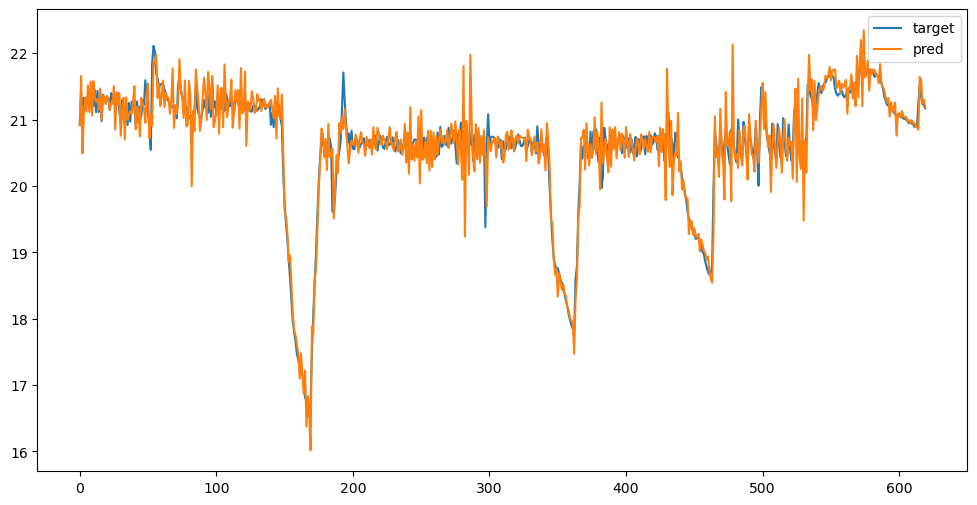

In [20]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

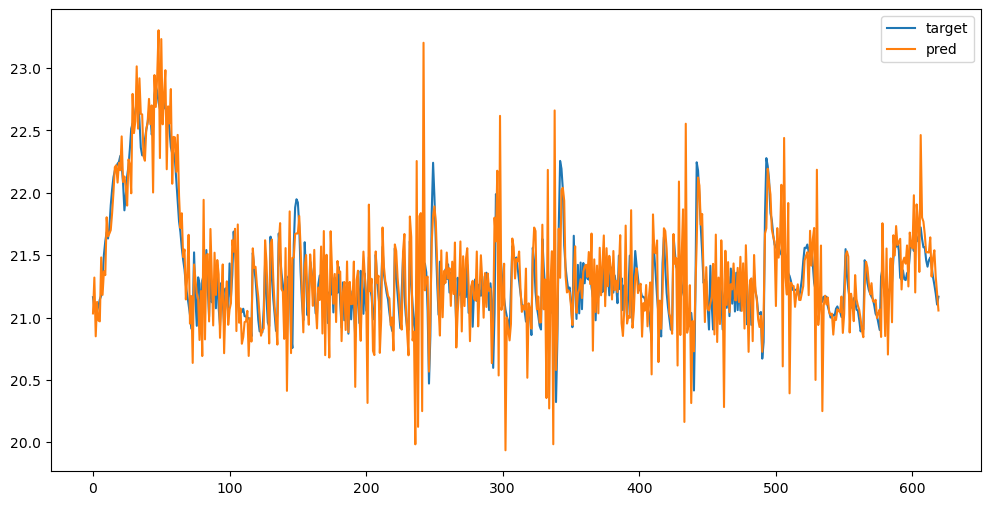

In [21]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.legend()

#### Physics-consistent

Check if the model good for control-oriented applications.

In [22]:
u_fake = u_train[[100], ::]
x_fake = x_train[[100], ::]

q_hvac = jnp.array([0.1*i for i in range(-100, 100)])
n_points = len(q_hvac)

others = jnp.tile(u_fake[:,:,1:], reps=(n_points, 1, 1))
q_hvac = q_hvac.reshape(-1,1)[:, jnp.newaxis, :]
q_hvac.shape, others.shape

u = jnp.concatenate((q_hvac, others), axis=-1)
x = jnp.tile(x_fake, reps=(n_points, 1))

y_pred = vmodel.apply(train_state.params, x, u)

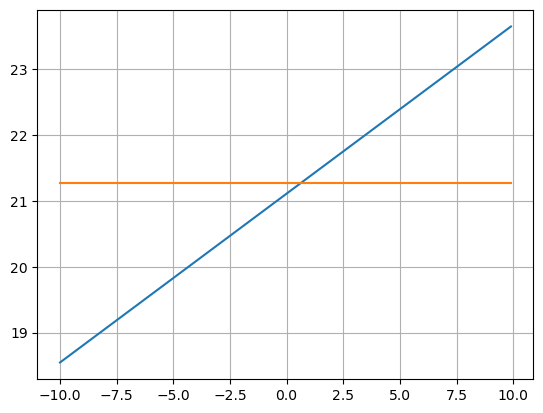

In [23]:
plt.figure()
plt.plot(q_hvac.squeeze(), y_pred, label='predicted') #
plt.plot(q_hvac.squeeze(), x, label='previous temp') # previous temperature
plt.grid()

### 1.3 Physics-informed Neural ODE

In this section, I will use physics-informed neural ODE to learn the dynamics of the system.

$$
    \frac{dT_z}{dt} = \frac{1}{C}q_{hvac} + f(h_t, T_o, \dot q_{sol}, \dot q_{hvac}; \theta)
$$


#### Prepare Data

In [24]:
target_col = 'temp_zone'
feature_col = ['qheat', 'temp_out', 'qsol', 'hour', 'weekday']

lags = 8
cols = [target_col] + feature_col
data3 = add_lags(data[cols], cols, lags)
data3 = data3.dropna()
print(data3.head())

# split training and testing
ratio = 0.25
n_train = int(len(data3)*ratio)
data_train = data3.iloc[:n_train, :]
data_test = data3.iloc[n_train:, :]

# get cols with lags
lag_cols = []
if lags:
    for lag in range(1, lags):
        for col in feature_col:
            lag_cols.append(col + '-' + str(lag))

# to model signals
x_train = jnp.array(data_train.loc[:, 'temp_zone-1'].values) 
u_train = jnp.array(data_train.loc[:, feature_col + lag_cols].values)
y_train = jnp.array(data_train.loc[:, target_col].values)

# normalize
normalize=False
if normalize:
    u_mean = u_train.mean(axis=0)
    u_std = u_train.std(axis=0)
    u_train = (u_train - u_mean) / u_std

# reshape for model
x_train = jnp.reshape(x_train, (-1,1))
u_train = jnp.expand_dims(u_train, axis=1)
y_train = jnp.reshape(y_train, (-1,1)) 

print("we have a training data set of :", u_train.shape[0])


x_test = jnp.array(data_test.loc[:, 'temp_zone-1'].values) 
u_test = jnp.array(data_test.loc[:, feature_col + lag_cols].values)
y_test = jnp.array(data_test.loc[:, target_col].values)
if normalize:
    u_test = (u_test - u_mean) / u_std
x_test = jnp.reshape(x_test, (-1,1))
u_test = jnp.expand_dims(u_test, axis=1)
y_test = jnp.reshape(y_test, (-1,1))
print("we have a training data set of :", u_test.shape[0])


                     temp_zone     qheat  temp_out  qsol  hour  weekday  \
time                                                                      
2018-01-14 20:00:00  20.918519  7.466667  5.712963   0.0    20        6   
2018-01-14 20:15:00  21.400000  0.000000  5.574074   0.0    20        6   
2018-01-14 20:30:00  20.985185  3.733333  5.435185   0.0    20        6   
2018-01-14 20:45:00  21.329630  3.733333  5.296296   0.0    20        6   
2018-01-14 21:00:00  21.162963  1.866667  5.189815   0.0    21        6   

                     temp_zone-1   qheat-1  temp_out-1  qsol-1  ...  \
time                                                            ...   
2018-01-14 20:00:00    21.192593  0.000000    5.851852     0.0  ...   
2018-01-14 20:15:00    20.918519  7.466667    5.712963     0.0  ...   
2018-01-14 20:30:00    21.400000  0.000000    5.574074     0.0  ...   
2018-01-14 20:45:00    20.985185  3.733333    5.435185     0.0  ...   
2018-01-14 21:00:00    21.329630  3.733333    5.

/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'-'+str(lag)] = data[col].shift(lag)
/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col+'-'+str(lag)] = data[col].shift(lag)
/tmp/ipykernel_3527/3858755773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

#### Define Model

In [25]:
INPUT_DIM = u_train.shape[-1]

class PINN(BaseContinuousBlockSSM):
    state_dim: int = 1
    input_dim: int = INPUT_DIM
    output_dim: int = 1

    def setup(self):
        super().setup()
        self._fx = self.fx(output_dim = self.state_dim)
        self._fy = self.fy(output_dim = self.output_dim)
    
    def __call__(self, states, inputs):
        # states: (B, nx)
        # inputs: (B, ni)
        return super().__call__(states, inputs)

    class fx(nn.Module):
        output_dim: int 
        def setup(self):
            self.C = self.param('C', nn.initializers.constant(1000.), ())
            #TODO: two observations:
            # 1. without relu, it is easier to train but may explode during training
            # 2. with relu, it is easier to get a smoother prediction
            self.disturbance = nn.Sequential([
                nn.Dense(32),
                nn.relu,
                nn.Dense(16),
                nn.relu,
                nn.Dense(4),
                #nn.relu,
                nn.Dense(features=self.output_dim),# use_bias=False),
                ])
        
        def __call__(self, states, inputs):
            # assumed the first input is q_hvac
            q_hvac = jnp.take(inputs, jnp.array([0]), axis=-1)
            others = jnp.take(inputs, jnp.arange(1, jnp.shape(inputs)[-1]), axis=-1)
            # run model
            disturbance = self.disturbance(others)
            return 1./self.C * (q_hvac + disturbance)
    
    class fy(nn.Module):
        output_dim: int 

        def __call__(self, states, inputs):
            # a faked value
            return states @ jnp.eye(1)

ode = PINN()
key = jax.random.PRNGKey(2023)
init_params = ode.init(key, jnp.ones((4,1)), jnp.ones((4,32)))
rhs, out = ode.apply(init_params, jnp.ones((4,1)), jnp.ones((4,32)))
print(ode.tabulate(key, jnp.ones((4,1)), jnp.ones((4,32))))


                                  PINN Summary                                  
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path           ┃ module     ┃ inputs        ┃ outputs        ┃ params        ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│                │ PINN       │ -             │ - float32[4,1] │               │
│                │            │ float32[4,1]  │ - float32[4,1] │               │
│                │            │ -             │                │               │
│                │            │ float32[4,32] │                │               │
├────────────────┼────────────┼───────────────┼────────────────┼───────────────┤
│ _fx            │ fx         │ -             │ float32[4,1]   │ C: float32[]  │
│                │            │ float32[4,1]  │                │               │
│                │            │ -             │                │ 1 (4 B)       │
│                │         

In [26]:
class PINNModel(nn.Module):
    
    state_dim: int = 1
    ts: int = 0
    dt: int = 900
    regularizer:callable = nn.relu

    @nn.compact 
    def __call__(self, states, inputs):

        dynamics = PINN(state_dim = self.state_dim, name='dynamic')
        states_out, measures_out = DifferentiableSimulator(
            dynamics, 
            dt=self.dt, 
            mode_interp='linear', 
            start_time=self.ts
        )(states, inputs)
        
        # add regularizer for loss calculation
        if self.regularizer is not None:
            # a reduce function to get the last value in sow(), which stores previous value
            reduce_fn = lambda a, b: b 
            param_dynamics = dynamics.variables['params']['_fx']['C']
            self.sow('reg_loss', 'C', self.regularizer(param_dynamics), reduce_fn=reduce_fn)

        return jnp.squeeze(states_out, axis=-1)

In [27]:
# added a parameter regulizer
params_bounds = [5000, 10000]
def param_regularizer(params, params_bounds):
    lb, ub = params_bounds
    loss = nn.relu(params - ub) + nn.relu(lb - params)
    return loss

In [28]:
model = PINNModel(state_dim=1, regularizer=lambda params: param_regularizer(params, params_bounds))

key = jax.random.PRNGKey(2023)
init_params = model.init(key, jnp.ones((1)), jnp.ones((4,32)))
init_out, model_states = model.apply(init_params, jnp.ones((1,)), jnp.ones((4,32)), mutable=['reg_loss'])
print(model_states)
print(model.tabulate(key, jnp.ones((1,)), jnp.ones((4,32))))

{'reg_loss': {'C': Array(4000., dtype=float32)}}

                               PINNModel Summary                                
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ reg_loss   ┃ params      ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│            │ PINNModel  │ -          │ float32[4] │ C:         │             │
│            │            │ float32[1] │            │ float32[]  │             │
│            │            │ -          │            │            │             │
│            │            │ float32[4… │            │ 1 (4 B)    │             │
├────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Different… │ Different… │ -          │ -          │            │             │
│            │            │ float32[1] │ float32[4… │            │             │
│            │            │ -          │ -          │      

In [29]:
# batch Model with shared parameters
VModel = nn.vmap(PINNModel, in_axes=(0,0), out_axes=0, variable_axes={'params': None, 'reg_loss': None}, split_rngs={'params': False})
vmodel = VModel(state_dim=1, regularizer=lambda params: param_regularizer(params, params_bounds))
init_params = vmodel.init(key, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)))
out, states = vmodel.apply(init_params, jnp.ones((32,1)), jnp.ones((32,4,INPUT_DIM)), mutable=['reg_loss'])
print(out.shape)

(32, 4)


#### Training and Evaluation

In [30]:
u_train.shape

(310, 1, 40)

In [31]:
qhvac = jnp.take(u_train, jnp.array([0]), axis=-1)
qhvac.shape

others = jnp.take(u_train, jnp.arange(1, INPUT_DIM), axis=-1)
others.shape

(310, 1, 39)

In [32]:
# inverse simulation train_step
@jax.jit
def train_step(train_state, state_init, u, target):
    def mse_loss(params):
        # prediction
        outputs_pred, regulizers = train_state.apply_fn(params, state_init, u, mutable=['reg_loss'])
        #outputs_pred = jnp.clip(outputs_pred, 16., 40.)
        # mse loss: match dimensions
        pred_loss = jnp.mean((outputs_pred - target)**2)
        reg_loss = sum(jax.tree_util.tree_leaves(regulizers["reg_loss"]))

        return pred_loss + reg_loss
    
    loss, grad = jax.value_and_grad(mse_loss)(train_state.params)
    train_state = train_state.apply_gradients(grads=grad)

    return loss, grad, train_state

schedule = optax.linear_schedule(
    init_value = 1e-1, 
    transition_steps = 5000, 
    transition_begin=0, 
    end_value=1e-4
)

optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-04),
    optax.adam(0.1)
)

train_state = TrainState.create(
    apply_fn=vmodel.apply,
    params=init_params,
    tx = optim,
)


In [33]:
optim = optax.chain(
    #optax.clip_by_global_norm(1.0),
    #optax.clip(1.),
    #optax.scale(1.2),
    #optax.lamb(1e-03),
    optax.adam(0.001)
)

In [34]:
n_epochs = 500000

# train loop
for epoch in range(n_epochs):
    loss, grad, train_state = train_step(train_state, x_train, u_train, y_train)
    if epoch % 1000 == 0:
        print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 4047.28515625
epoch: 1000, loss: 3912.982177734375
epoch: 2000, loss: 3811.85498046875
epoch: 3000, loss: 3710.95556640625
epoch: 4000, loss: 3610.2138671875
epoch: 5000, loss: 3509.6337890625
epoch: 6000, loss: 3409.1123046875
epoch: 7000, loss: 3308.705322265625
epoch: 8000, loss: 3208.387939453125
epoch: 9000, loss: 3108.060791015625
epoch: 10000, loss: 3007.749755859375
epoch: 11000, loss: 2907.543701171875
epoch: 12000, loss: 2807.440185546875
epoch: 13000, loss: 2707.36865234375
epoch: 14000, loss: 2607.32373046875
epoch: 15000, loss: 2507.2412109375
epoch: 16000, loss: 2406.993408203125
epoch: 17000, loss: 2306.761962890625
epoch: 18000, loss: 2206.544677734375
epoch: 19000, loss: 2106.339599609375
epoch: 20000, loss: 2006.14501953125
epoch: 21000, loss: 1905.959716796875
epoch: 22000, loss: 1805.7823486328125
epoch: 23000, loss: 1705.6123046875
epoch: 24000, loss: 1605.448486328125
epoch: 25000, loss: 1505.290283203125
epoch: 26000, loss: 1405.1370849609375
epoc

In [35]:
loss

Array(0.19208507, dtype=float32)

In [36]:
grad

{'params': {'dynamic': {'_fx': {'C': Array(-2.5035935e-05, dtype=float32),
    'disturbance': {'layers_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
      'kernel': Array([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)},
     'layers_2': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
      'kernel': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 

In [37]:
train_state.params

{'params': {'dynamic': {'_fx': {'C': Array(9997.722, dtype=float32),
    'disturbance': {'layers_0': {'bias': Array([-0.60054624, -0.6005463 , -0.6005462 , -0.4429462 , -0.16699333,
             -0.45526388, -0.83997506, -0.7944913 , -0.7876596 , -0.72828966,
              0.69422835, -0.6005465 , -0.11701839, -0.45583916, -0.8441569 ,
             -0.24465452, -0.44565013, -0.4540601 , -0.4375487 , -0.426342  ,
             -0.80664736, -0.45315292,  0.4749276 ,  0.        , -0.60054624,
             -0.60054666, -0.45462632, -0.58857316, -0.43780574,  0.6826198 ,
             -0.7780821 ,  0.6477948 ], dtype=float32),
      'kernel': Array([[ 0.31520426,  0.40710574,  0.5772775 , ..., -0.73833704,
               0.28259963, -0.8790774 ],
             [-0.4321541 , -0.49247518, -0.91386884, ...,  0.72130704,
              -0.606105  ,  0.73267466],
             [-0.7430649 , -0.4899143 , -0.5952114 , ...,  0.70327044,
              -0.81975824,  0.30479315],
             ...,
        

In [38]:
y_pred = vmodel.apply(train_state.params, x_train, u_train)
y_pred_test = vmodel.apply(train_state.params, x_test, u_test)

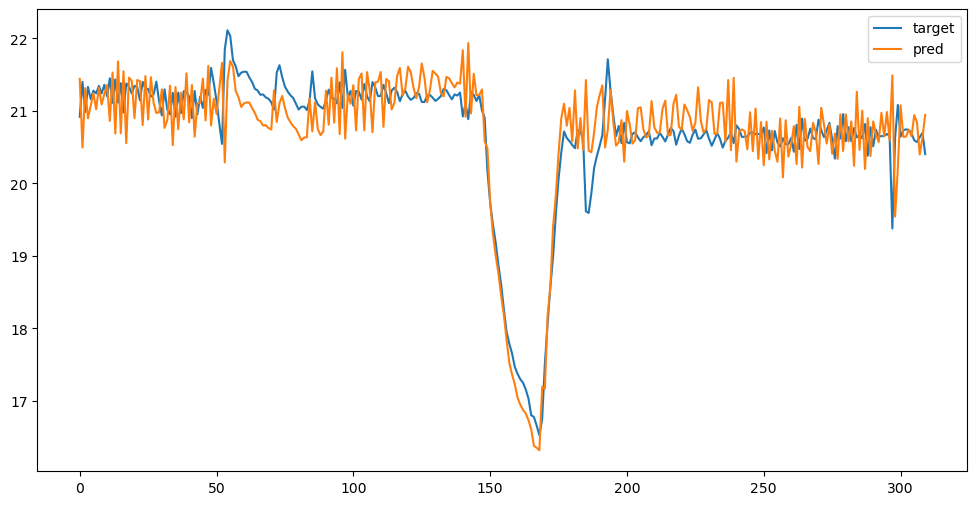

In [39]:
plt.figure(figsize=(12,6))
plt.plot(y_train[:,:], label='target')
plt.plot(y_pred[:,:], label='pred')
plt.legend()

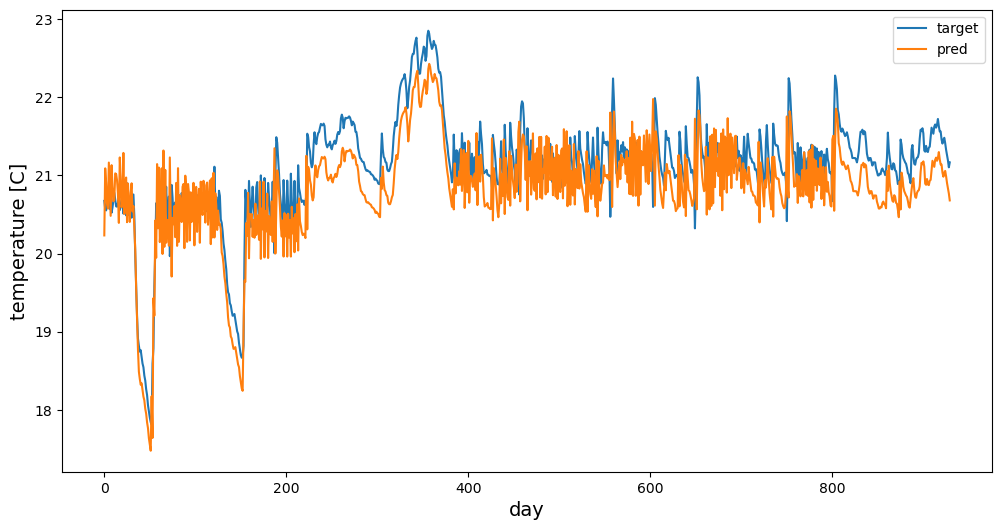

In [40]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.xlabel('day', fontsize=14)
plt.ylabel('temperature [C]', fontsize=14)
plt.legend()

In [41]:
# simple free-floating test
import numpy as np 
u_test1 = np.array(u_test)
u_test1[:, 0] = 0

y_pred_test1 = vmodel.apply(train_state.params, x_test, u_test1)

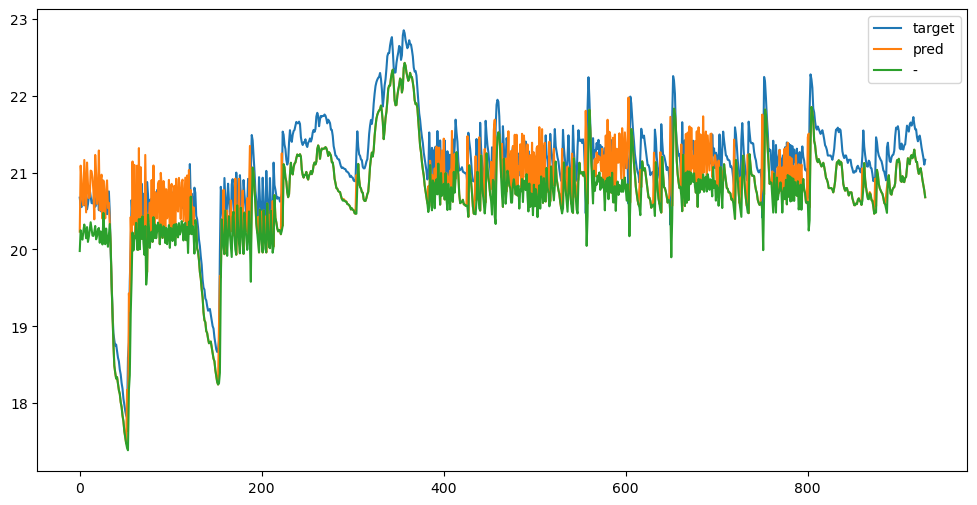

In [42]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:,:], label='target')
plt.plot(y_pred_test[:,:], label='pred')
plt.plot(y_pred_test1[:,:], label='-')
plt.legend()

## Physics-Consistent?

How to know if the learned model follows general physics? 
- the derivative of room temp with respect to the HVAC energy rate should be positive. The more heat injected to the room, the higher the room temperature.

In [43]:
u_fake = u_train[[100], ::]
x_fake = x_train[[100], ::]

In [44]:
u_fake.shape, x_fake.shape

((1, 1, 40), (1, 1))

In [45]:
#create 10 different points: 0-10 kW

q_hvac = jnp.array([i for i in range(-10, 10)])
n_points = len(q_hvac)

others = jnp.tile(u_fake[:,:,1:], reps=(n_points, 1, 1))
q_hvac = q_hvac.reshape(-1,1)[:, jnp.newaxis, :]
q_hvac.shape, others.shape

((20, 1, 1), (20, 1, 39))

In [46]:
u = jnp.concatenate((q_hvac, others), axis=-1)
x = jnp.tile(x_fake, reps=(n_points, 1))

In [47]:
y_pred = vmodel.apply(train_state.params, x, u)

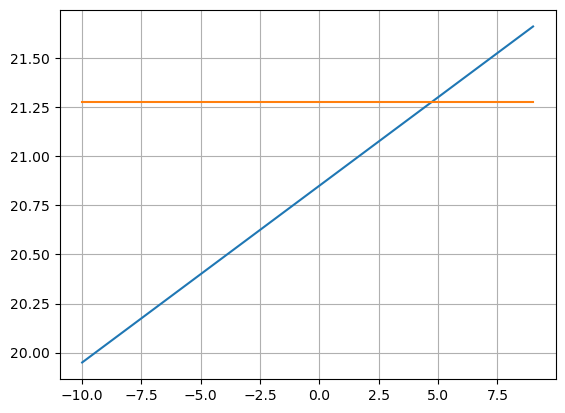

In [48]:
plt.figure()
plt.plot(q_hvac.squeeze(), y_pred, label='predicted') #
plt.plot(q_hvac.squeeze(), x, label='previous temp') # previous temperature
plt.grid()

In [49]:
0.1 

0.1